In [1]:
%load_ext autoreload
%autoreload 2
import torch

from data.dataset import PatientDataset
import pandas as pd
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, Dataset
import numpy as np
import models
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import load_model

In [2]:
images_path = "/home/filiptkac/Downloads/abd-trauma-dataset"
labels_path = "/home/filiptkac/Downloads/train_new_labels.csv"
labels_data = pd.read_csv(labels_path)

In [3]:
patient_dataset = PatientDataset(images_path, labels_data)
inputs, labels = patient_dataset[0]

# load your model here
model = models.ConvNet3D(
    in_channels=inputs.shape[0],
    out_channels=labels.shape[0],
    depth=inputs.shape[1],
    height=inputs.shape[2],
    width=inputs.shape[3],
)
load_model(model, "/home/filiptkac/Downloads/BEST_model.pth")

Model loaded from /home/filiptkac/Downloads/BEST_model.pth


In [4]:
class InjuriesDataset(Dataset):
    def __init__(self, dataset, label_to_keep):
        self.dataset = dataset
        self.label_to_keep = label_to_keep

        self.indices = [i for i, (_, labels) in enumerate(dataset) if torch.any(labels.int() == label_to_keep)]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        original_index = self.indices[index]
        return self.dataset[original_index]
    

def get_reduced_dataloader(dataset: PatientDataset, start_index = None, end_index = None, random_samples=5):
    if start_index is not None and end_index is not None:
        subset_range = range(start_index, end_index)
        subset_dataset = Subset(dataset, subset_range)
        return list(subset_range), DataLoader(subset_dataset, batch_size=1, shuffle=False)

    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    subset_indices = indices[:random_samples]
    sampler = SubsetRandomSampler(subset_indices)
    return subset_indices, DataLoader(dataset, batch_size=1, sampler=sampler)

def get_images_to_show(images_tensors):
    images = images_tensors.squeeze(0).squeeze(0)
    cut_indices = list(range(images.shape[0]))
    np.random.shuffle(cut_indices)
    images_indices = np.sort(cut_indices[:num_images_to_show])
    return images[images_indices]

def show_scans_with_labels(patient_id, num_images, scans, real_labels, predicted_labels):
    fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
    plt.suptitle(f"Patient ID {patient_id}", fontsize=22)

    for i in range(num_images):
        axes[0, i].imshow(scans[i], cmap='gray') 
        axes[0, i].axis('off')

    # remove empty figures from second row to make space for the table
    for i in range(num_images):
        axes[1, i].axis('off')

    cell_text = np.vstack((real_labels.int().numpy(), predicted_labels.numpy()))
    table = axes[1, 5].table(
        cellText=cell_text,
        loc='center',
        cellLoc='center',
        colLabels=["Bowel", "Extravasation", "Kidney", "Liver", "Spleen"],
        rowLabels=["Real (0 = no injury)", "Predicted"]
    )
    table.set_fontsize(18)
    table.auto_set_font_size(False)
    table.scale(7, 2.5)

    plt.subplots_adjust(top=0.85)
    plt.show()

In [7]:
injuries_dataset = InjuriesDataset(patient_dataset, 1)

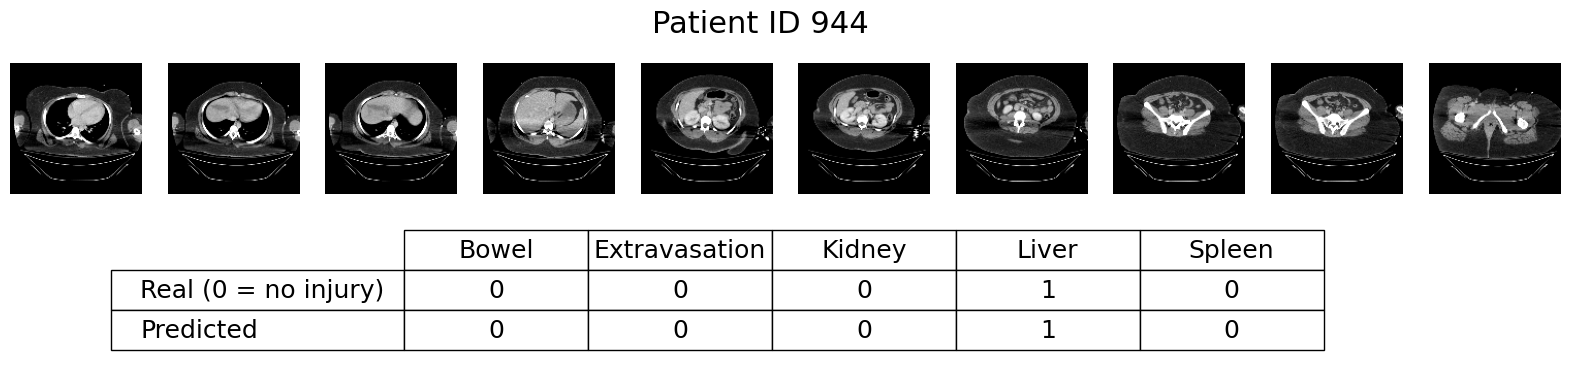

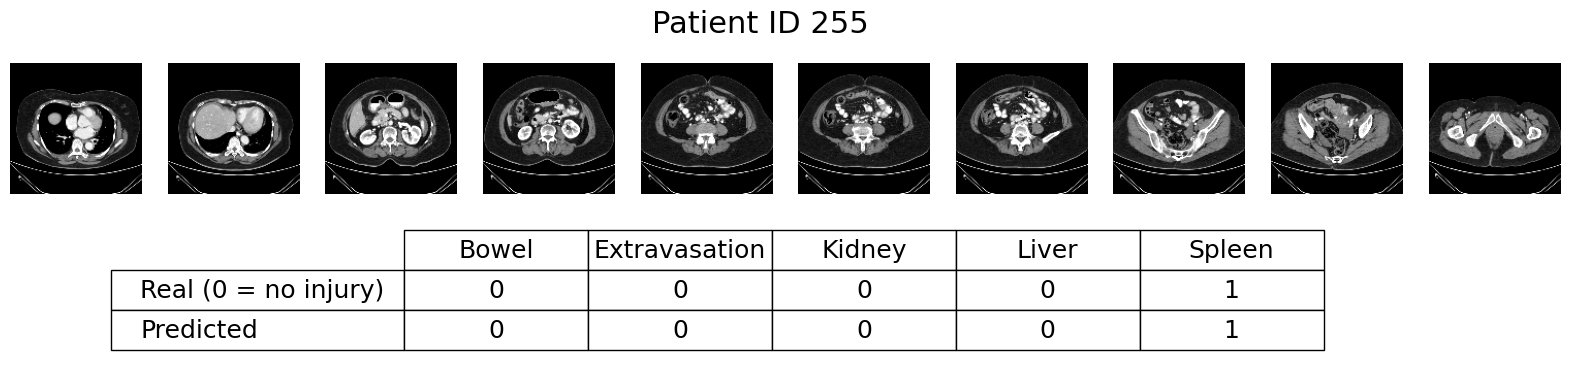

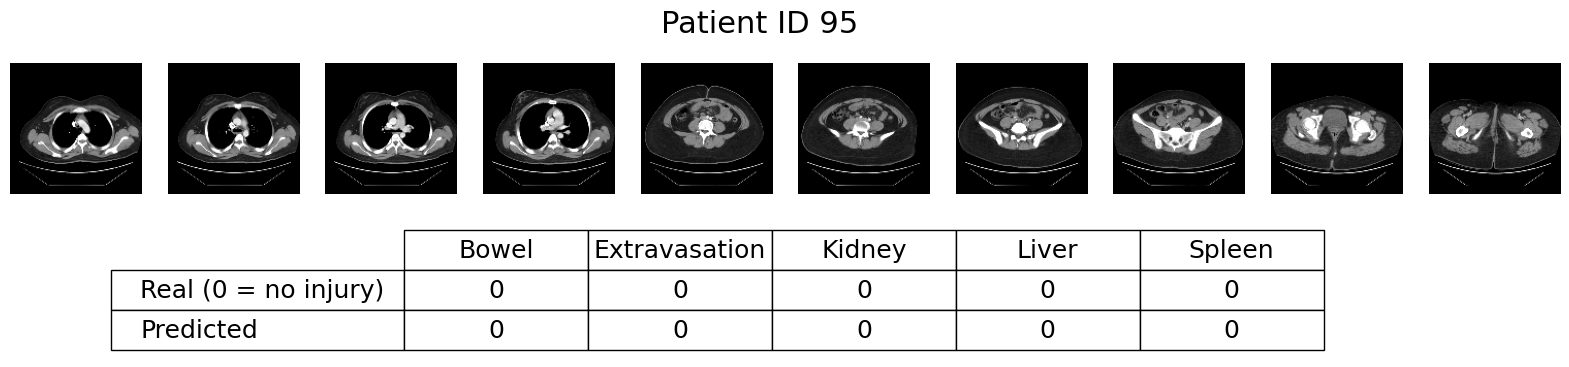

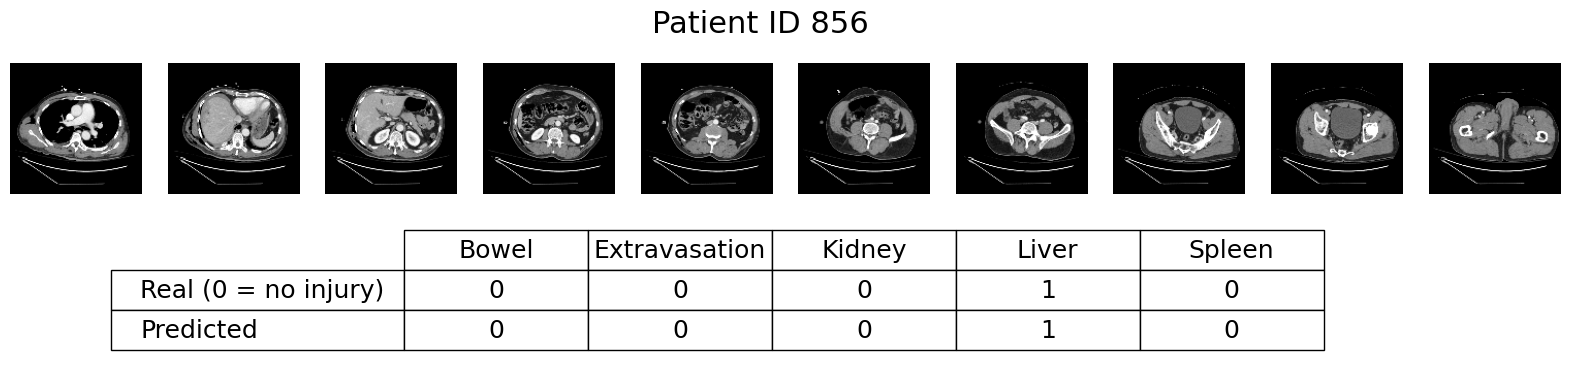

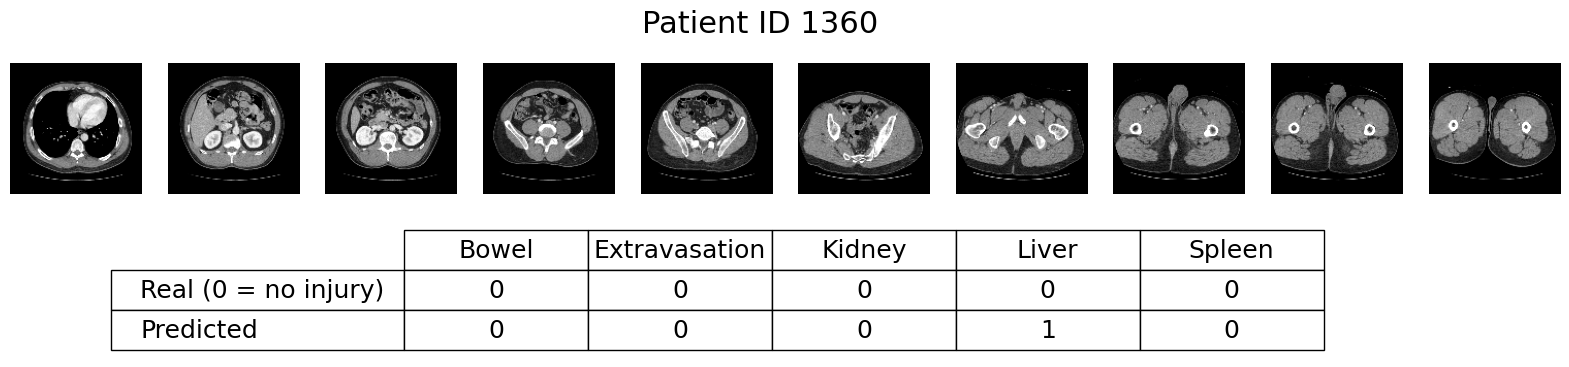

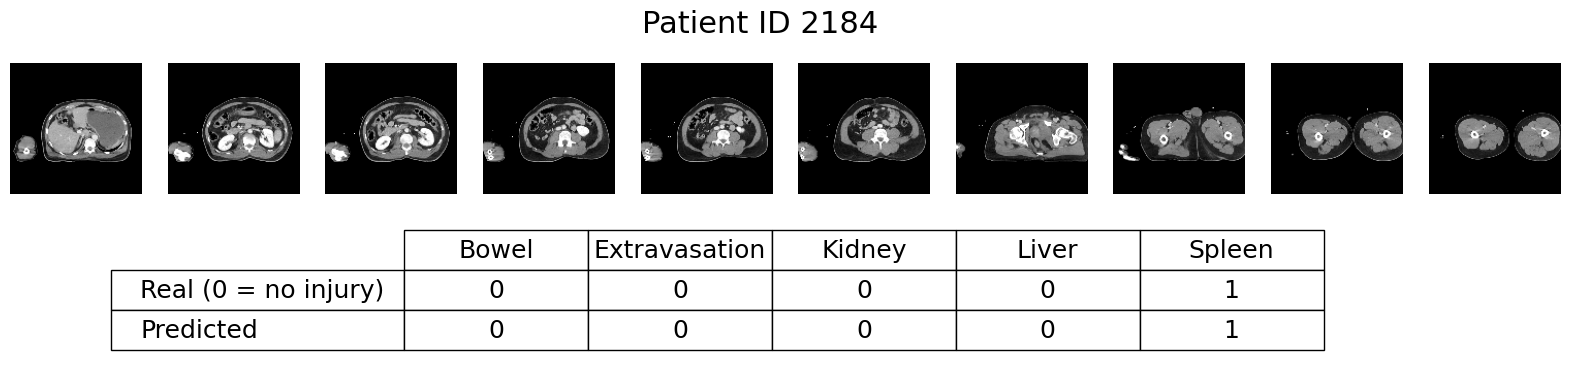

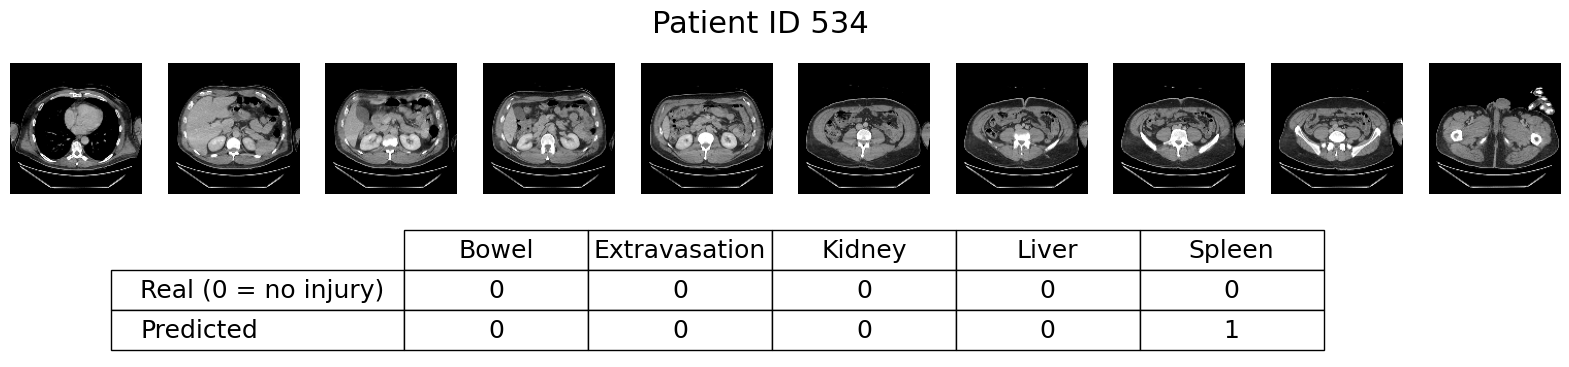

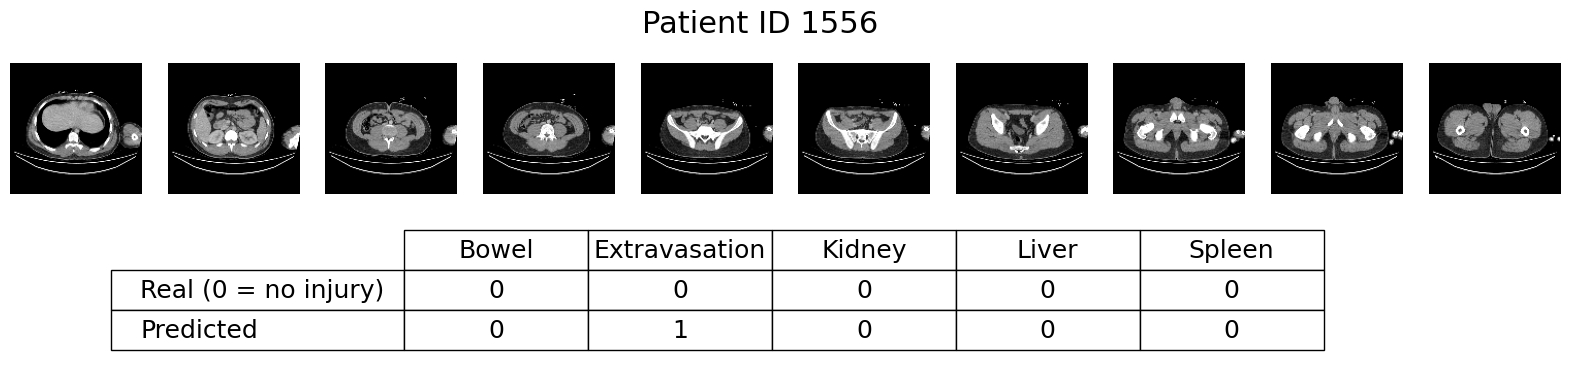

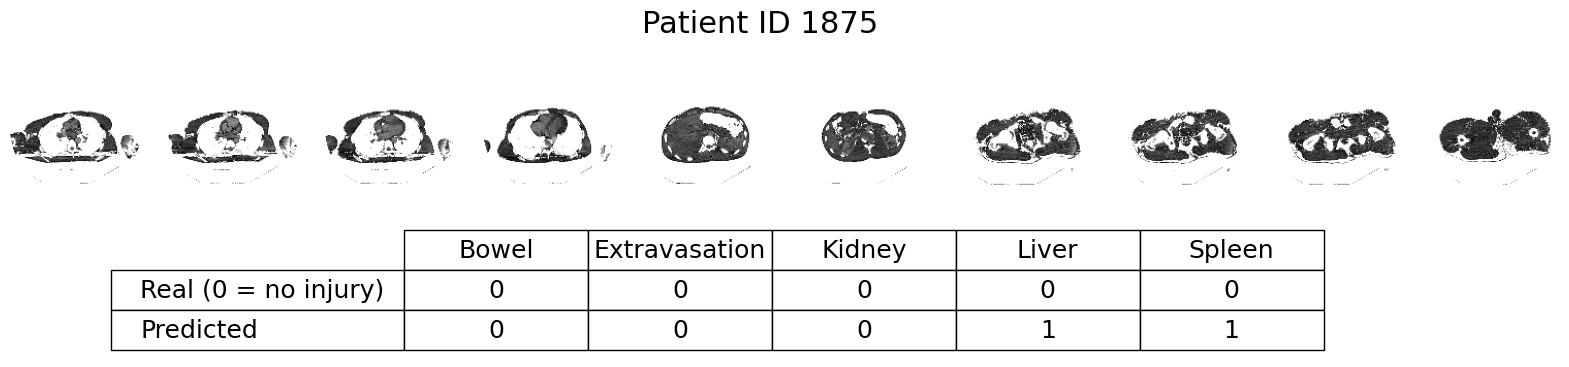

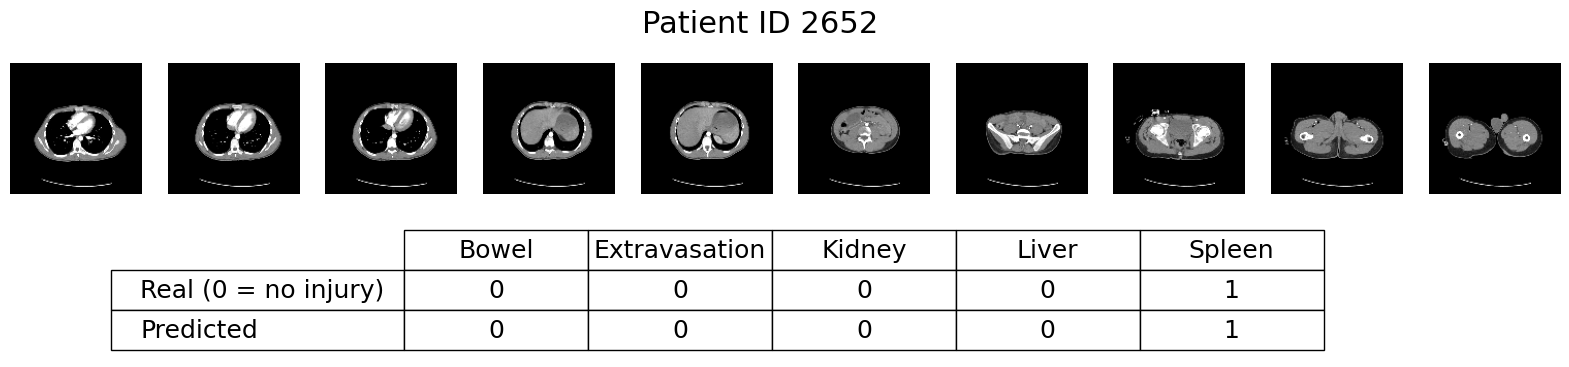

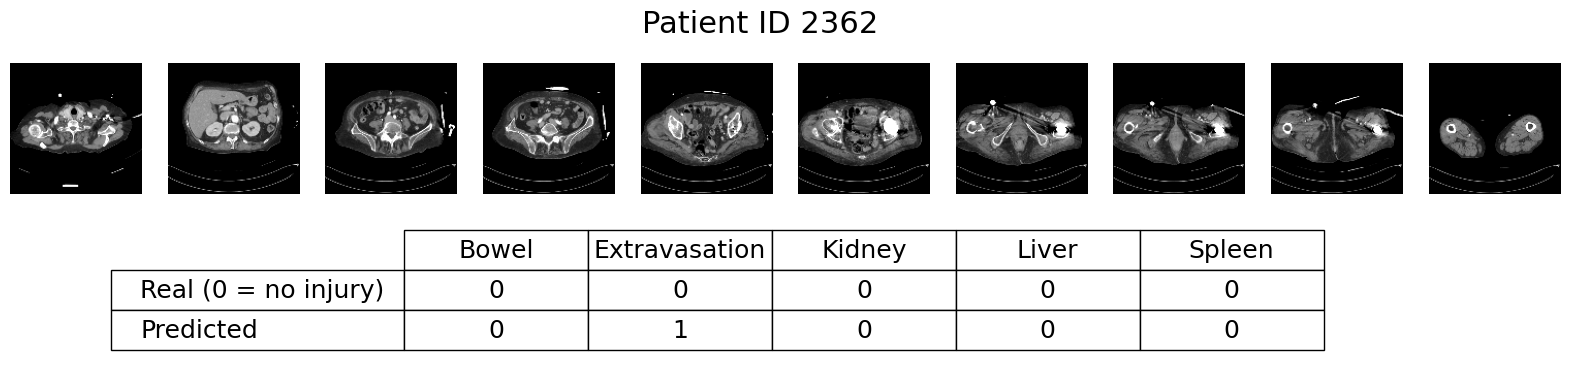

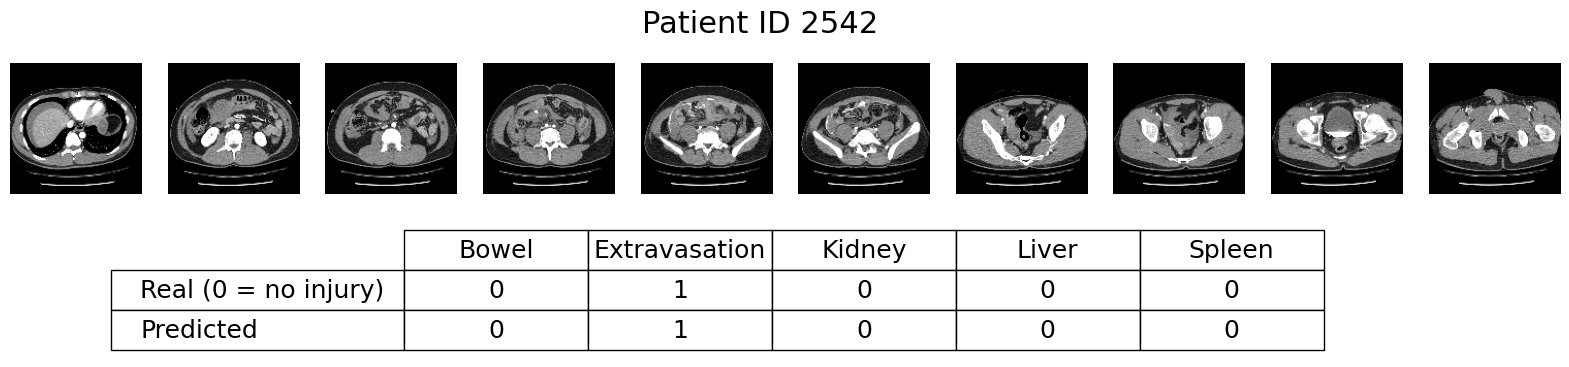

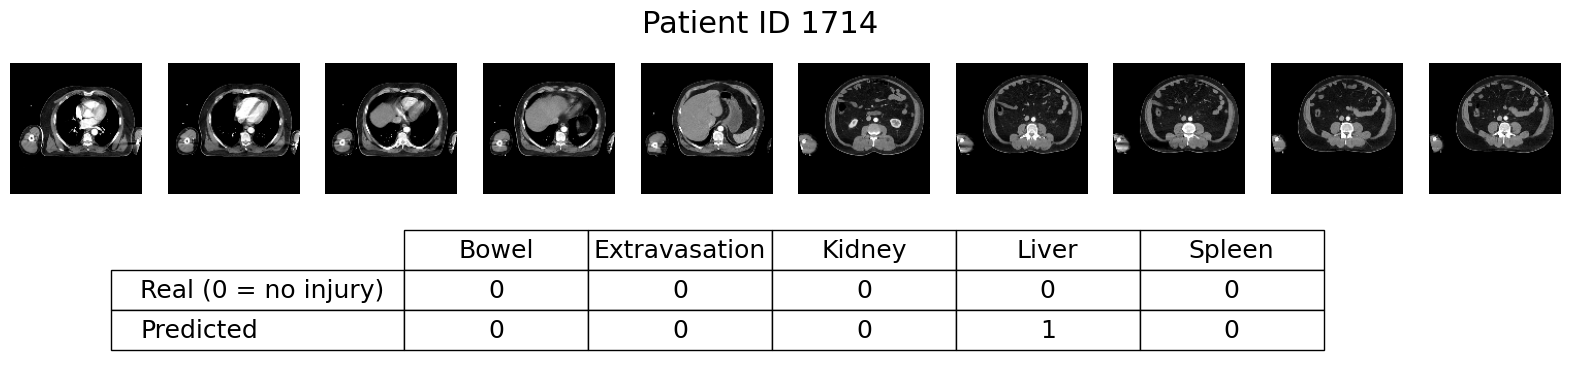

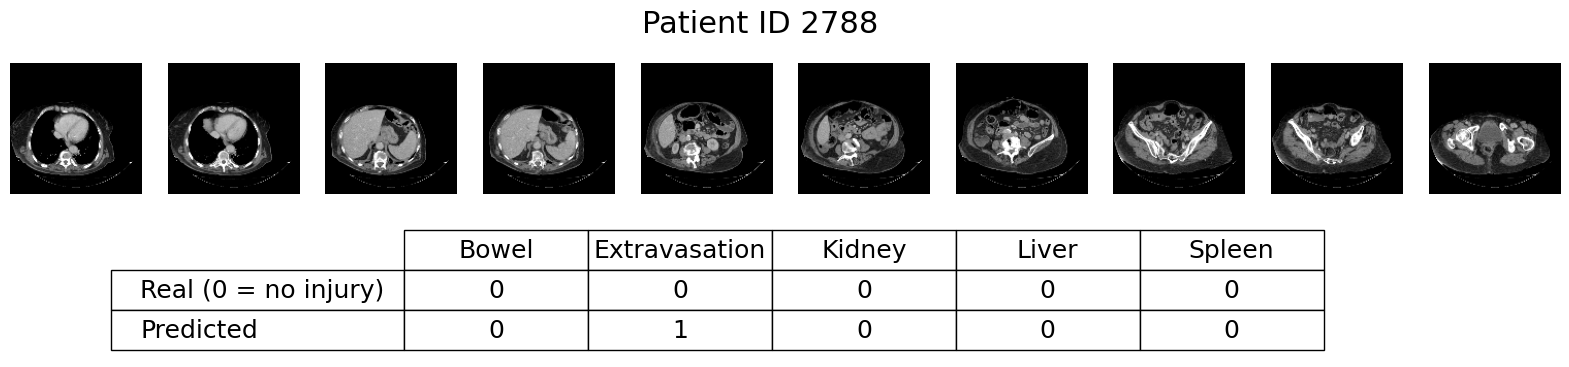

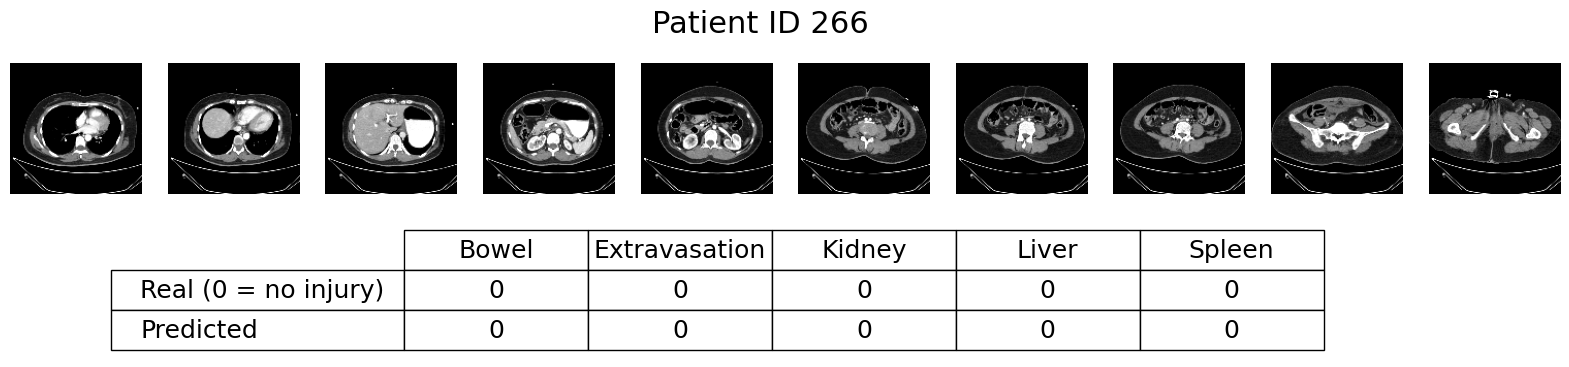

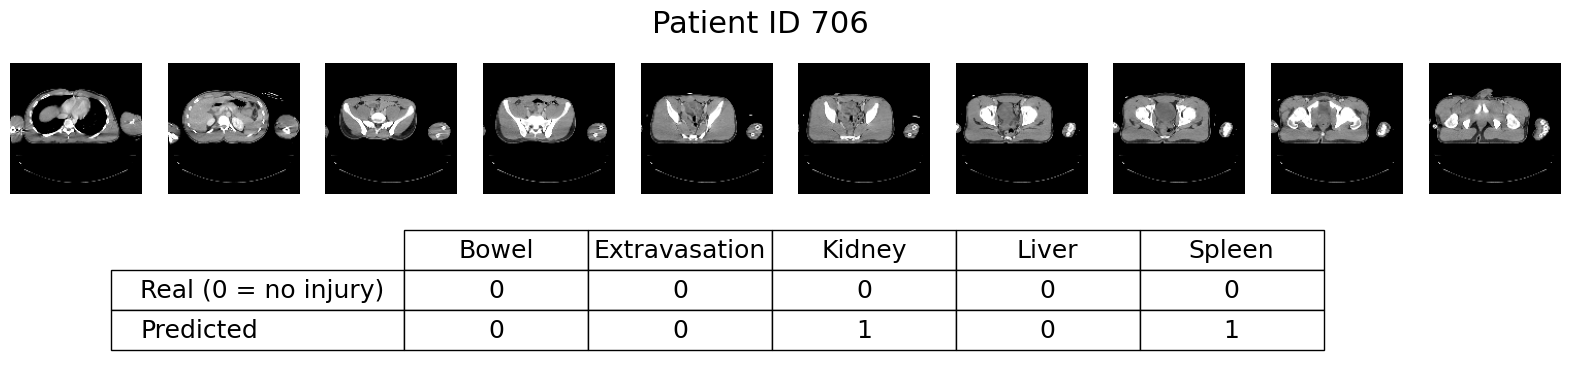

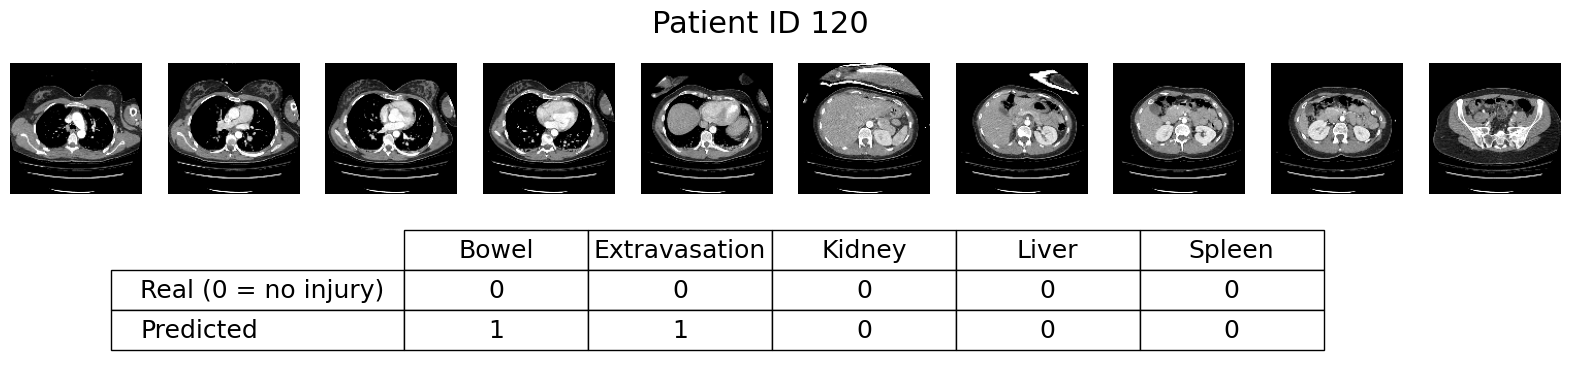

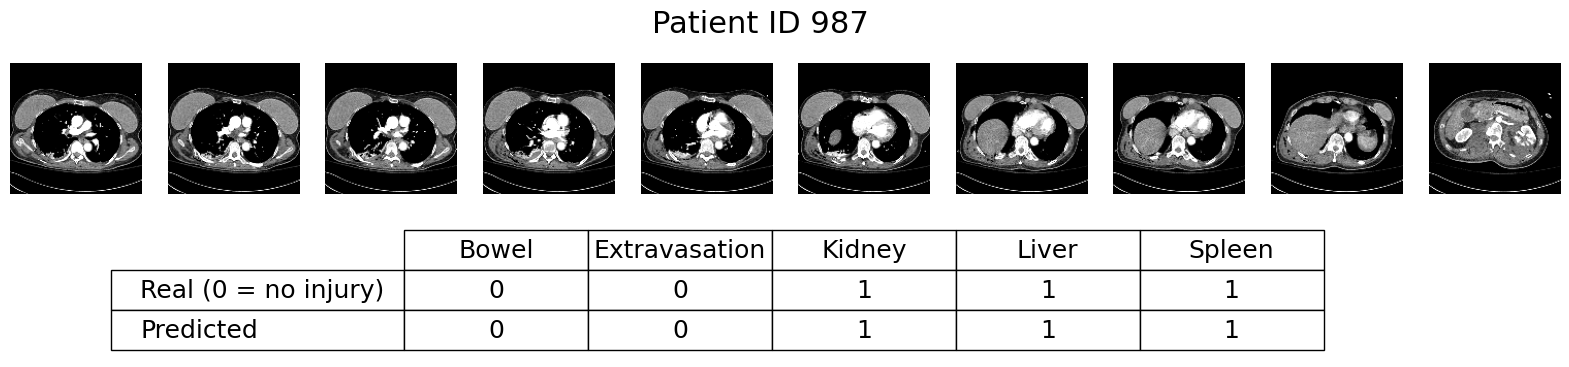

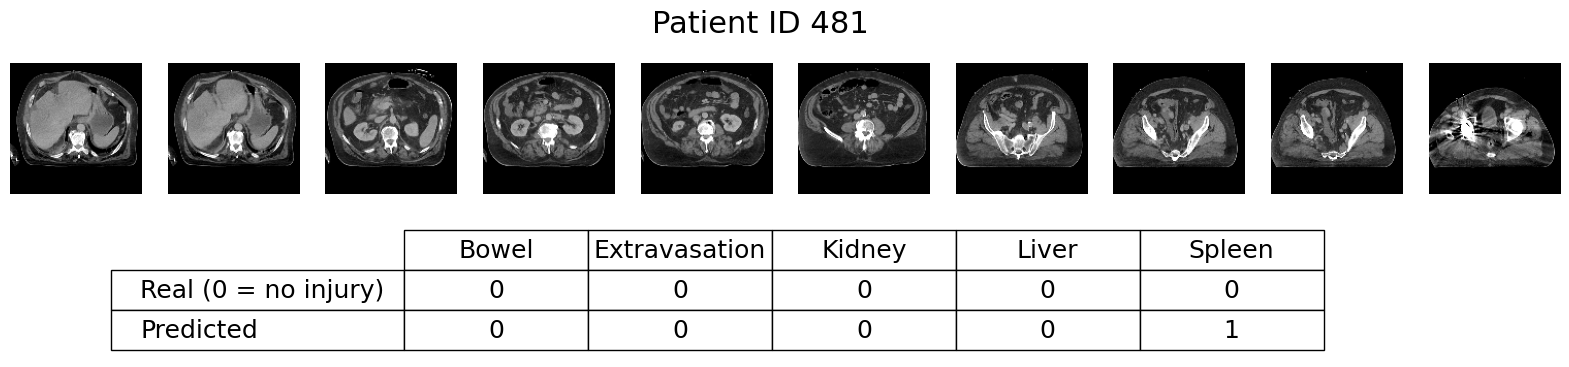

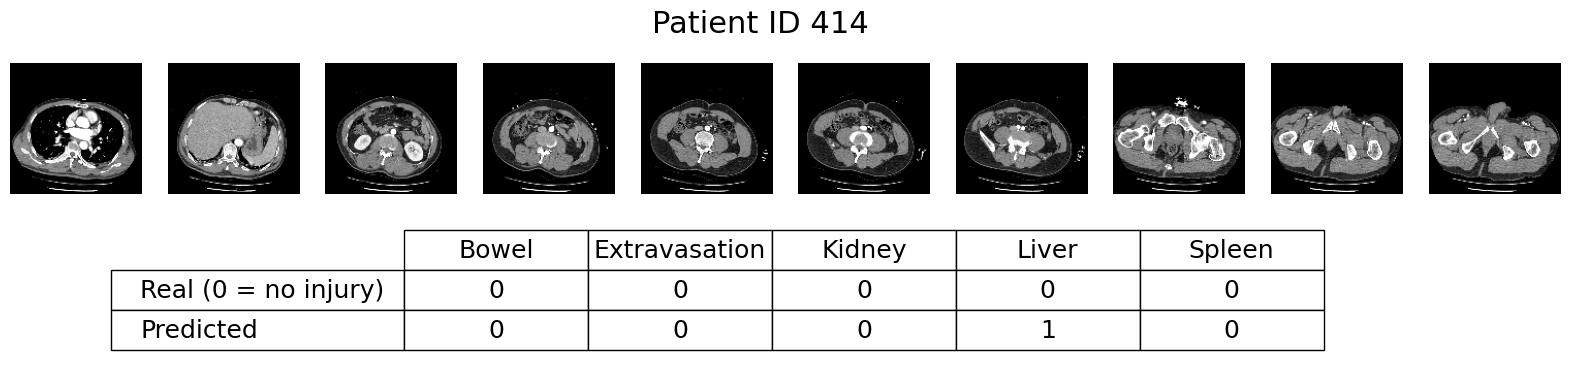

In [6]:
num_images_to_show = 10
model.eval()

# use injuries_dataset or patient_dataset
patient_ids, dataloader = get_reduced_dataloader(patient_dataset, random_samples=20)
for patient_index, (data, labels) in enumerate(dataloader):
    outputs = model(data.float())
    pred = (outputs > 0.5).int()

    images_to_show = get_images_to_show(data)
    
    show_scans_with_labels(patient_ids[patient_index], num_images_to_show, images_to_show, labels, pred)

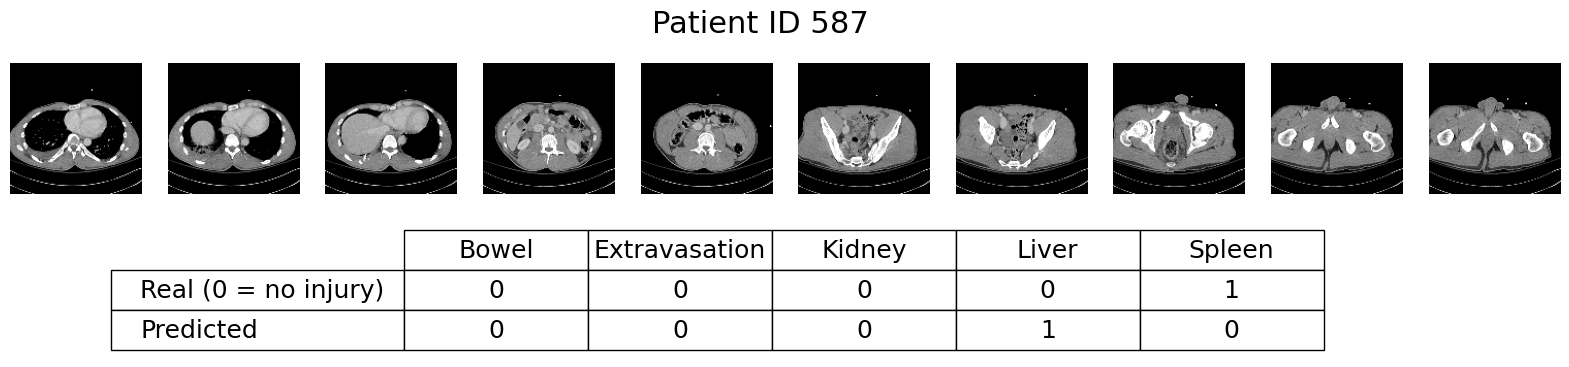

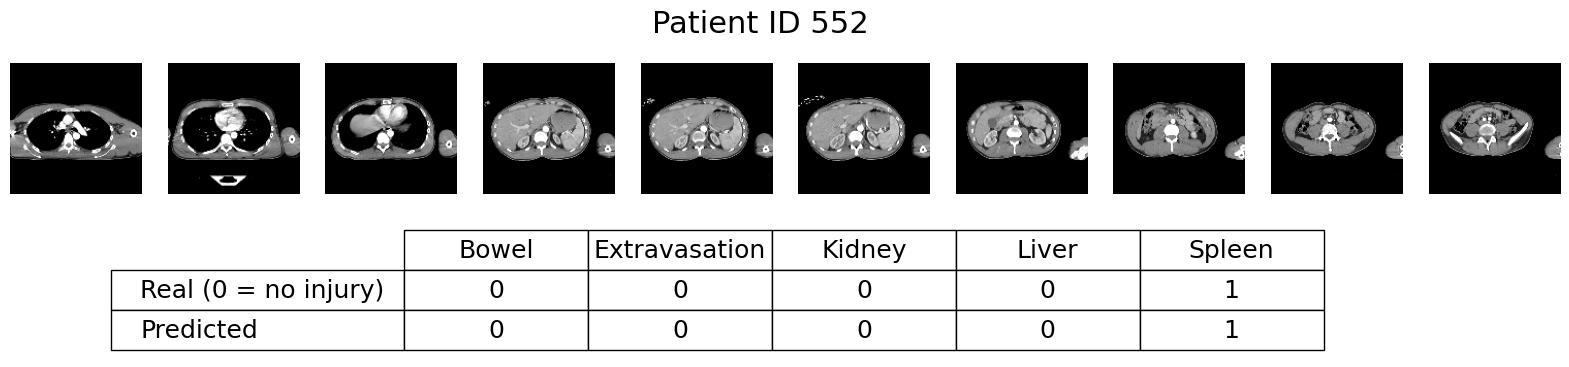

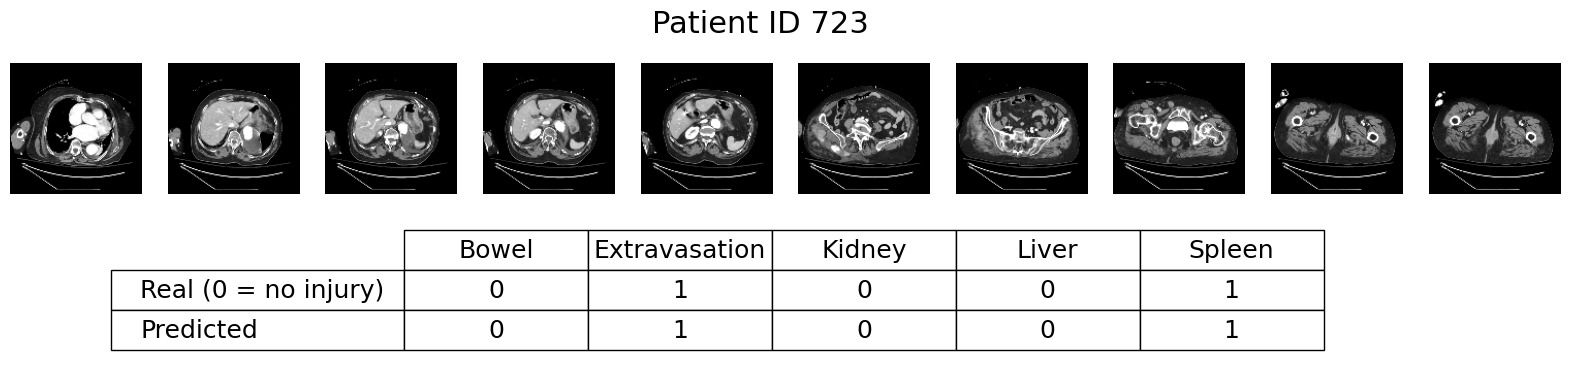

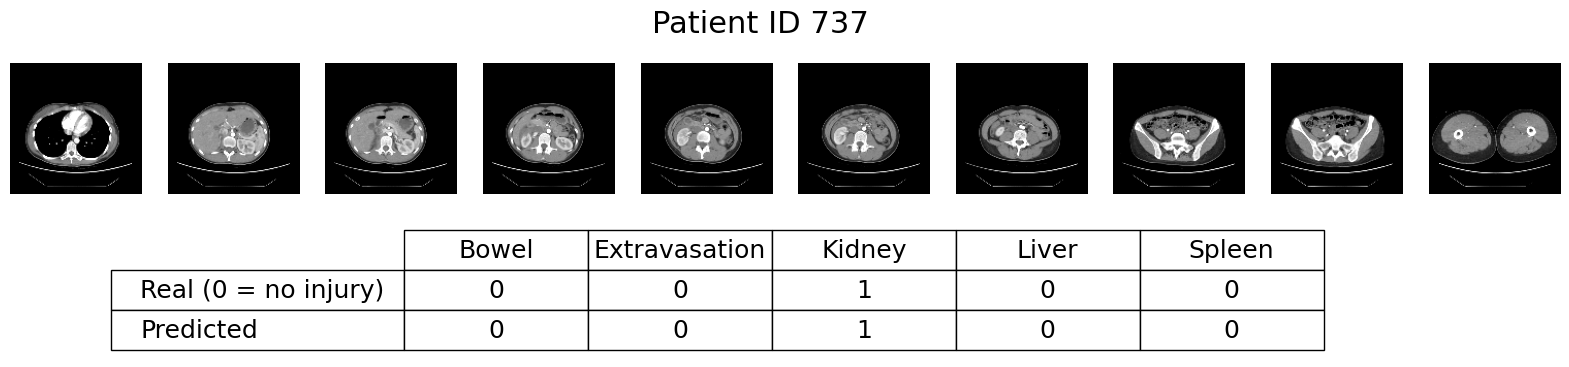

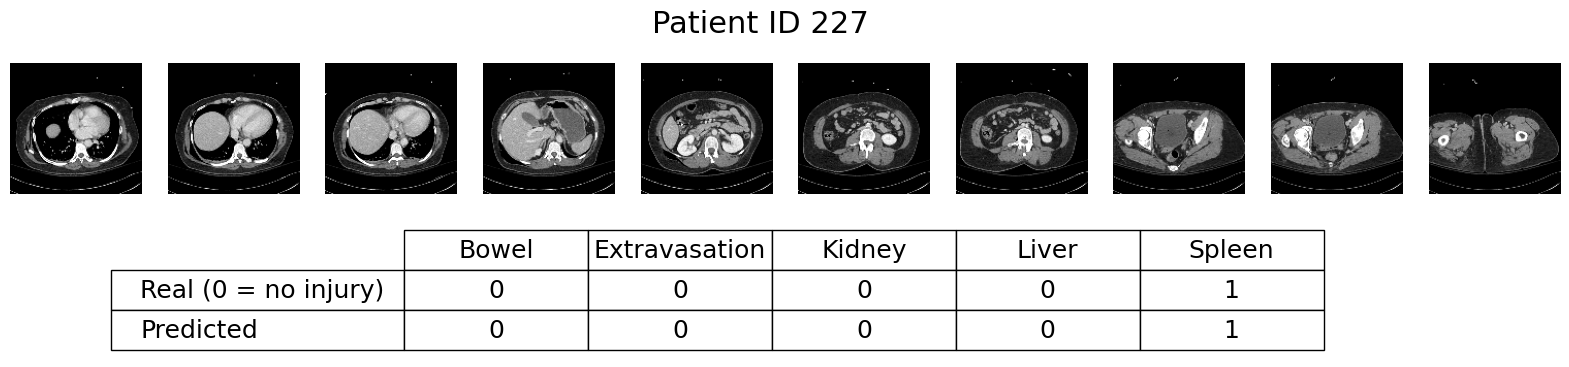

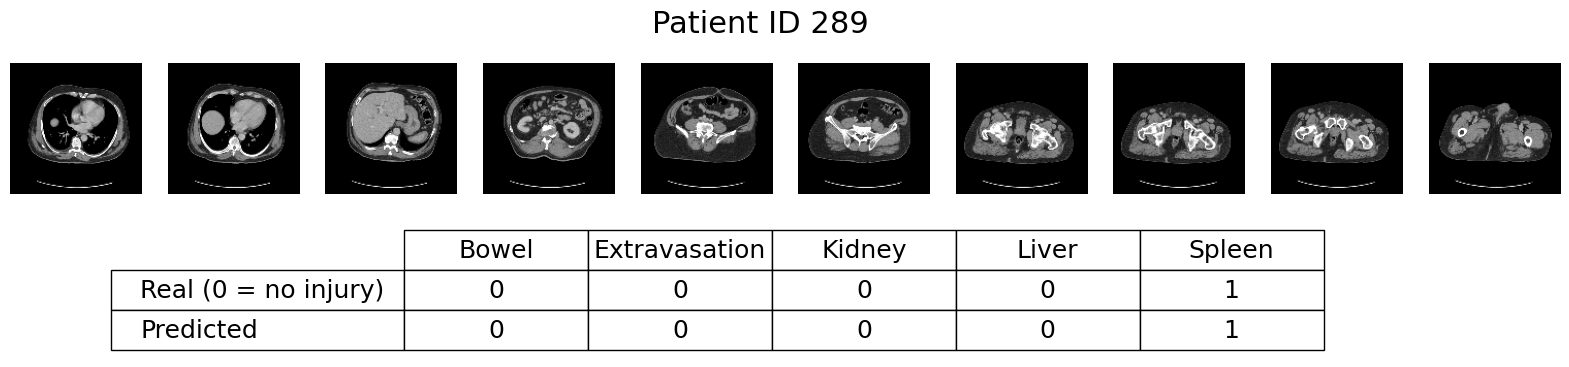

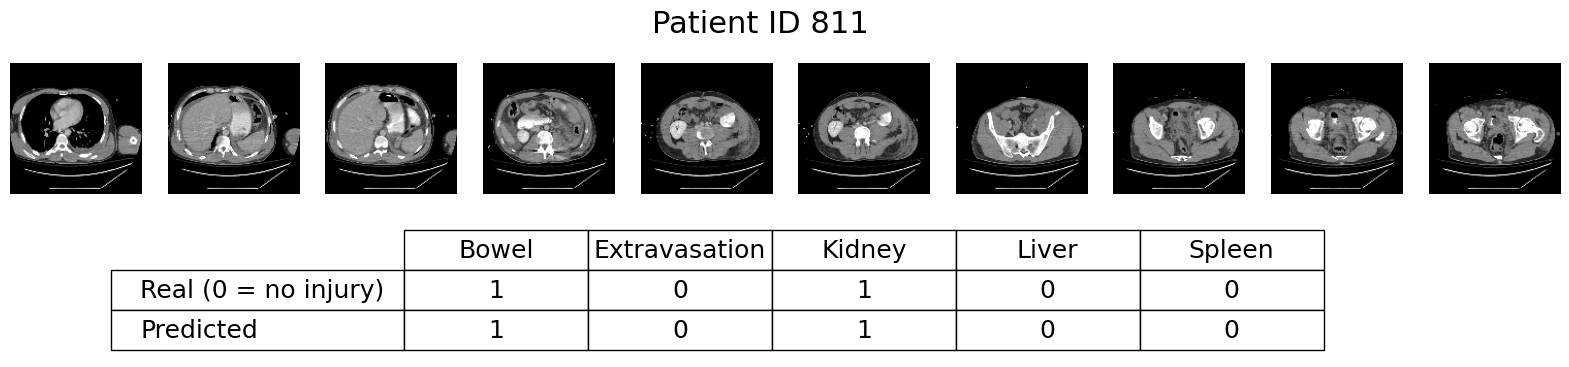

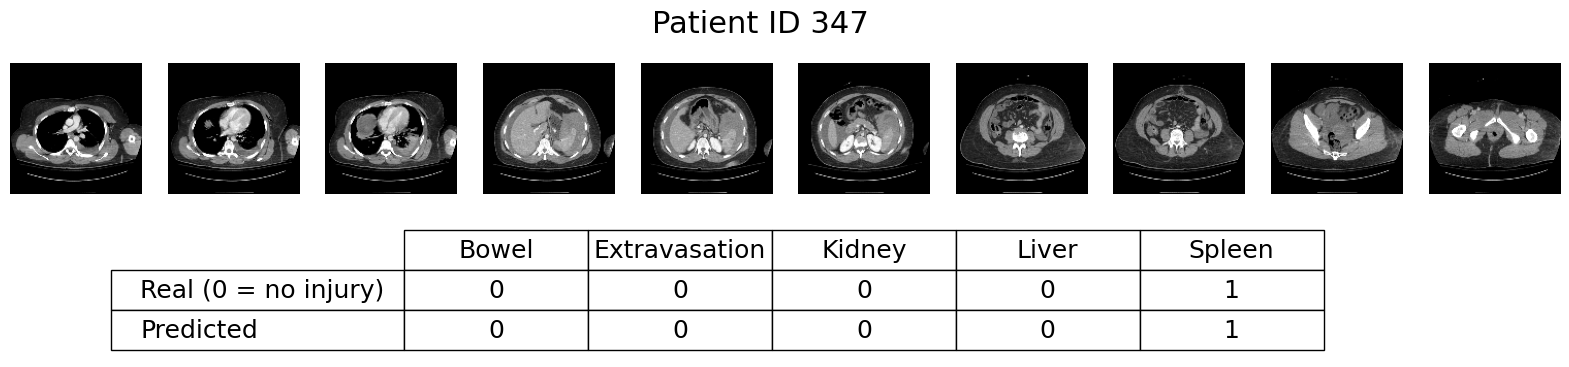

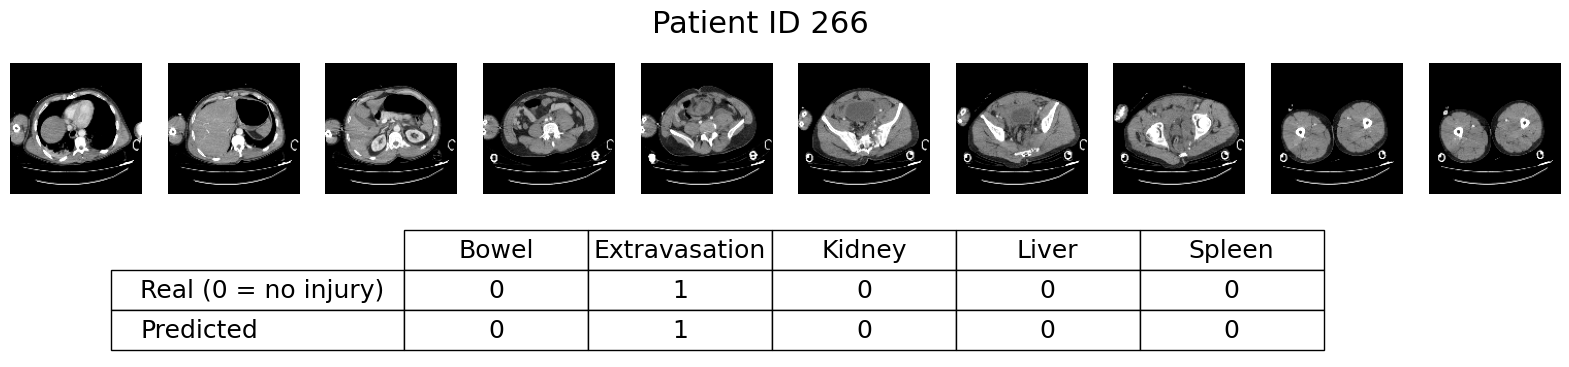

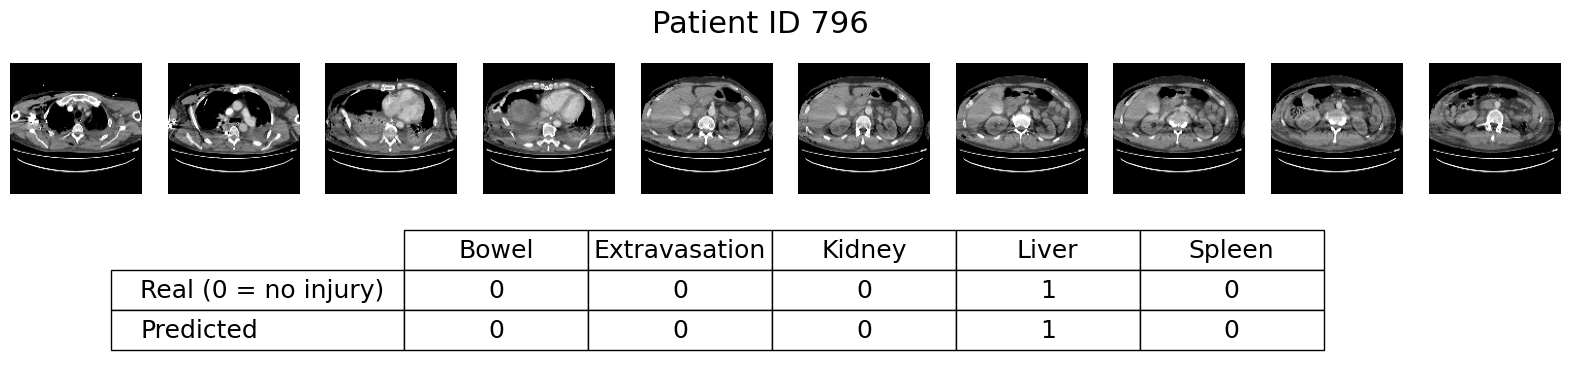

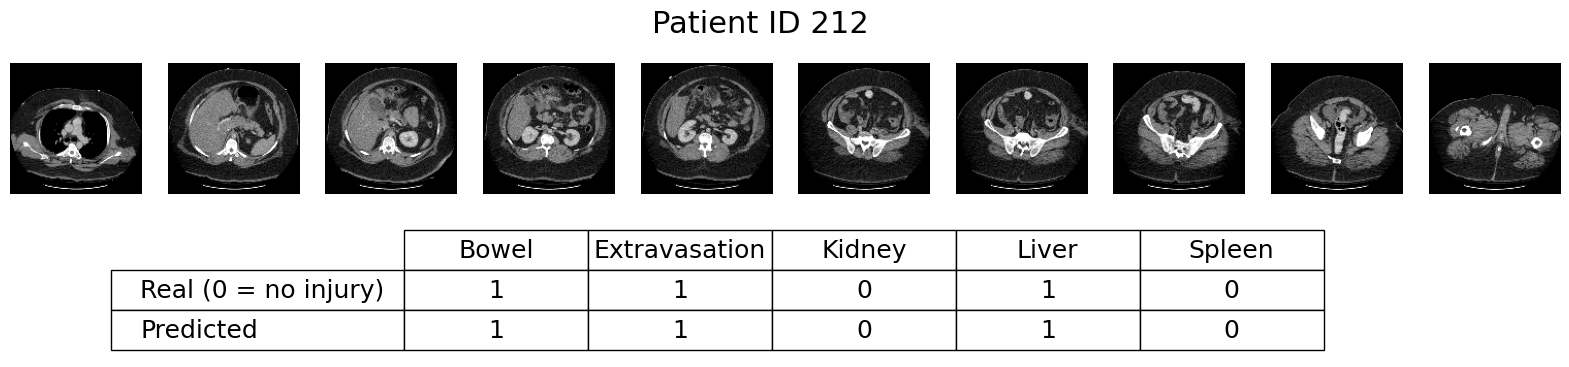

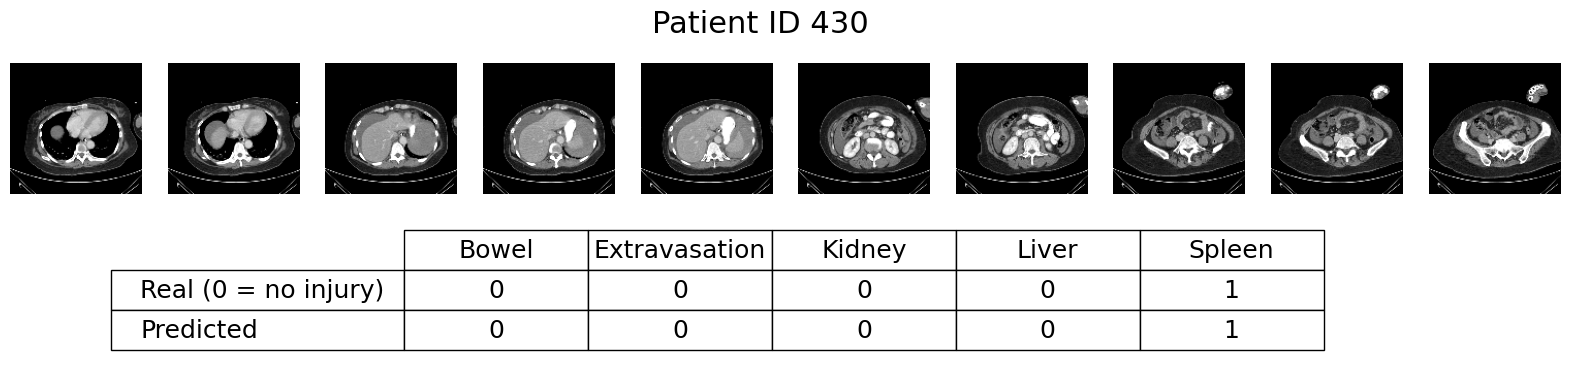

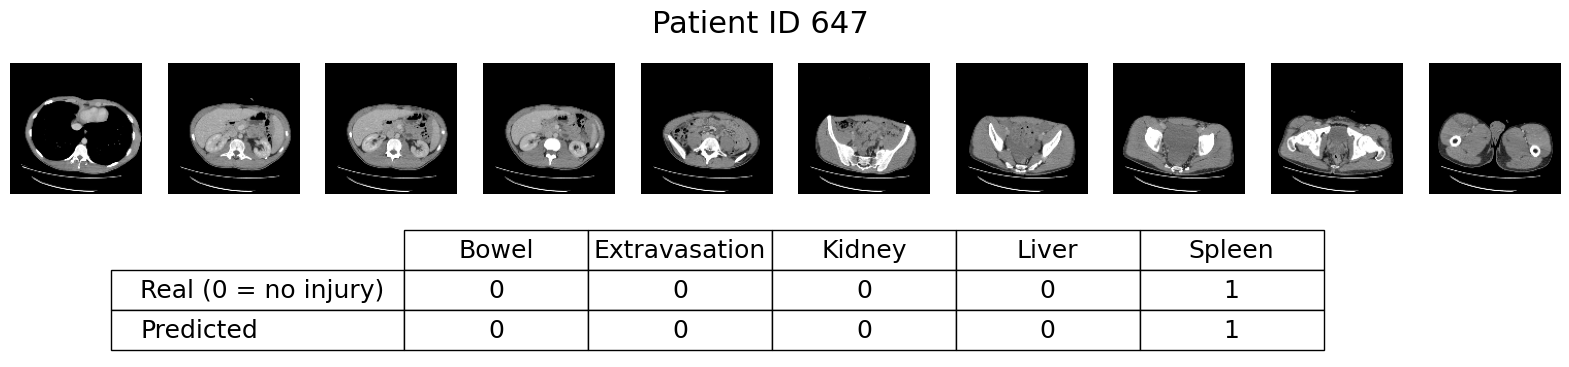

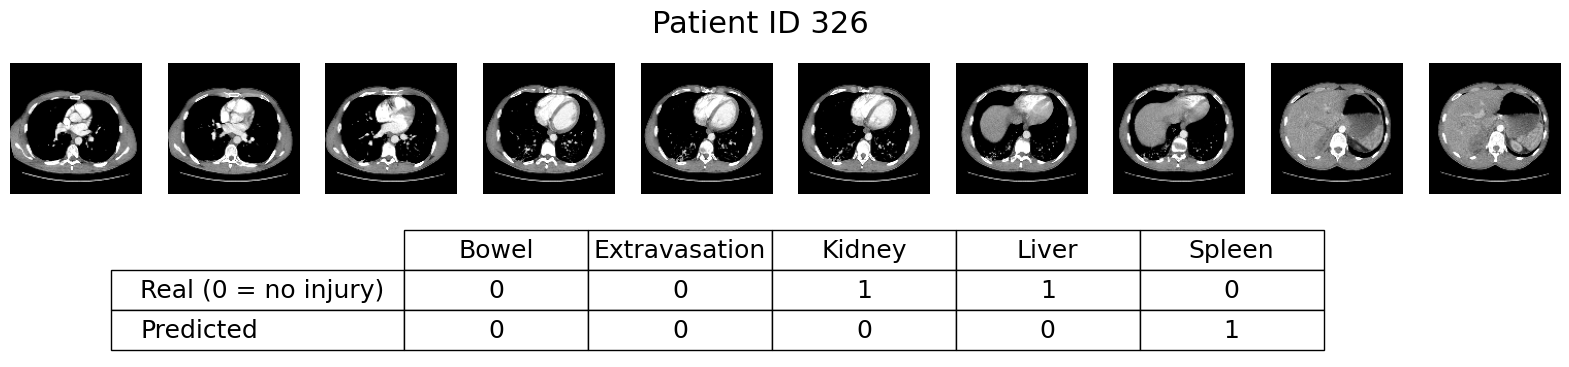

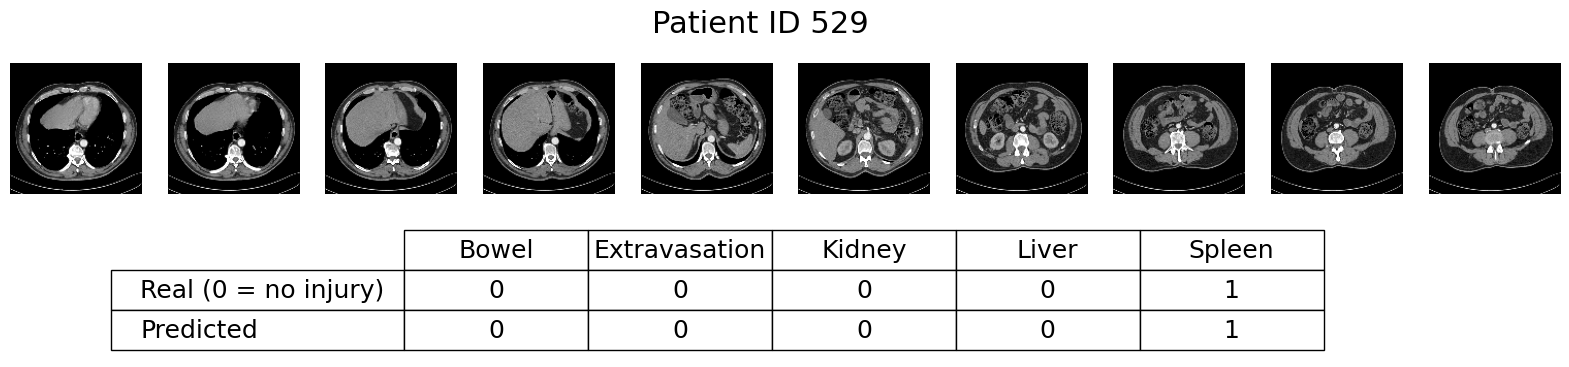

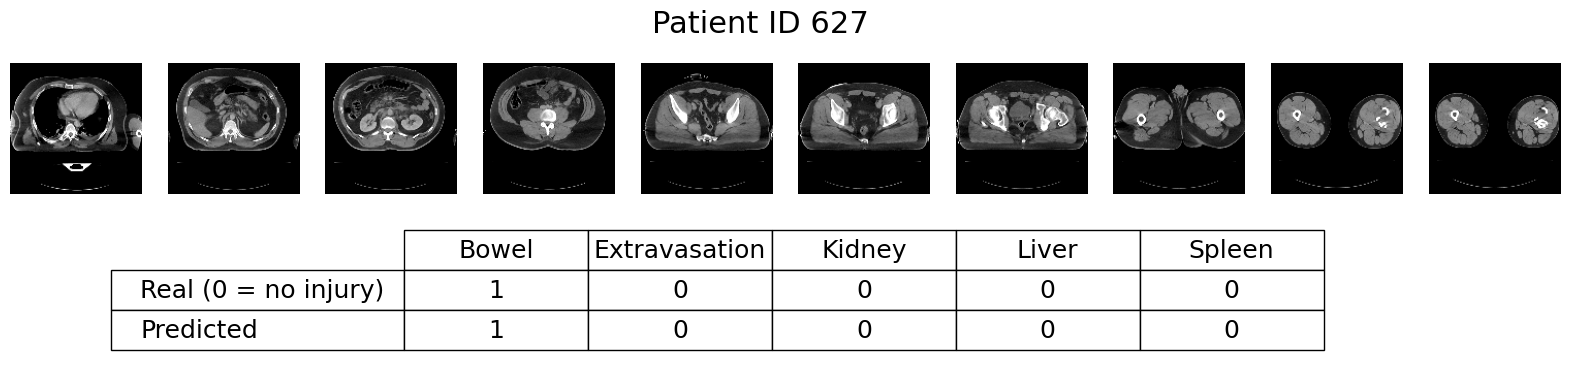

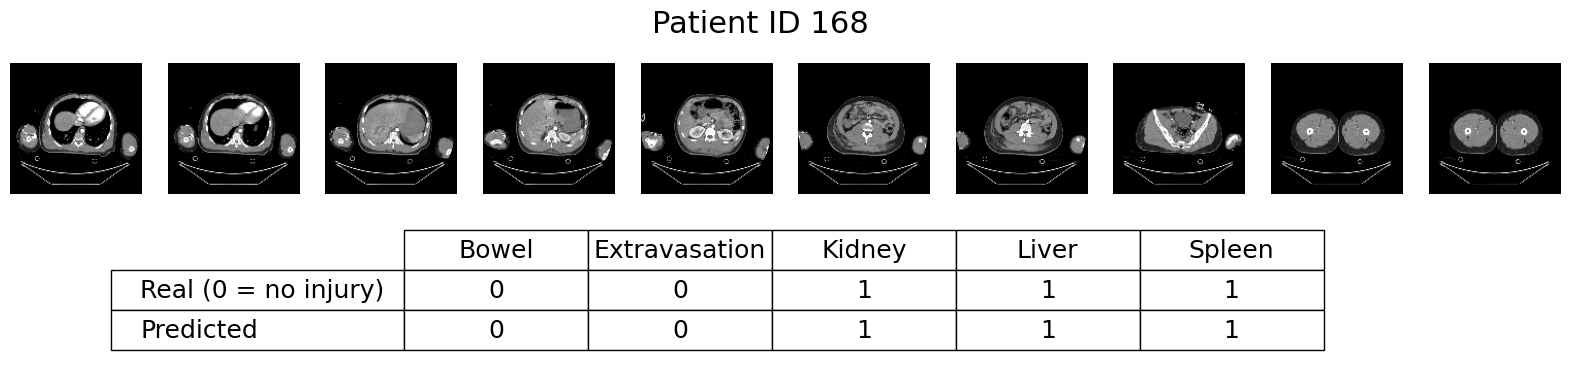

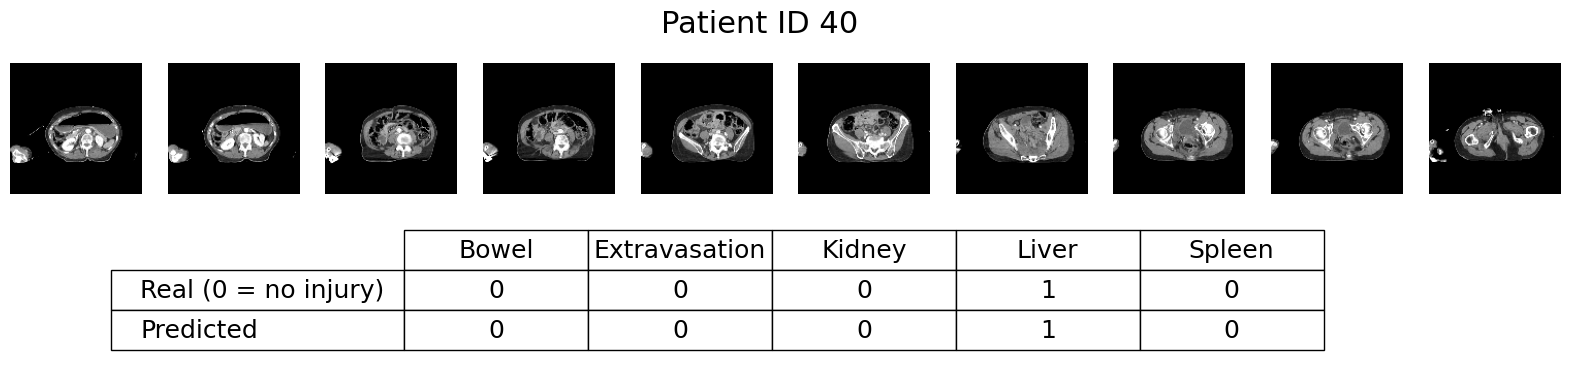

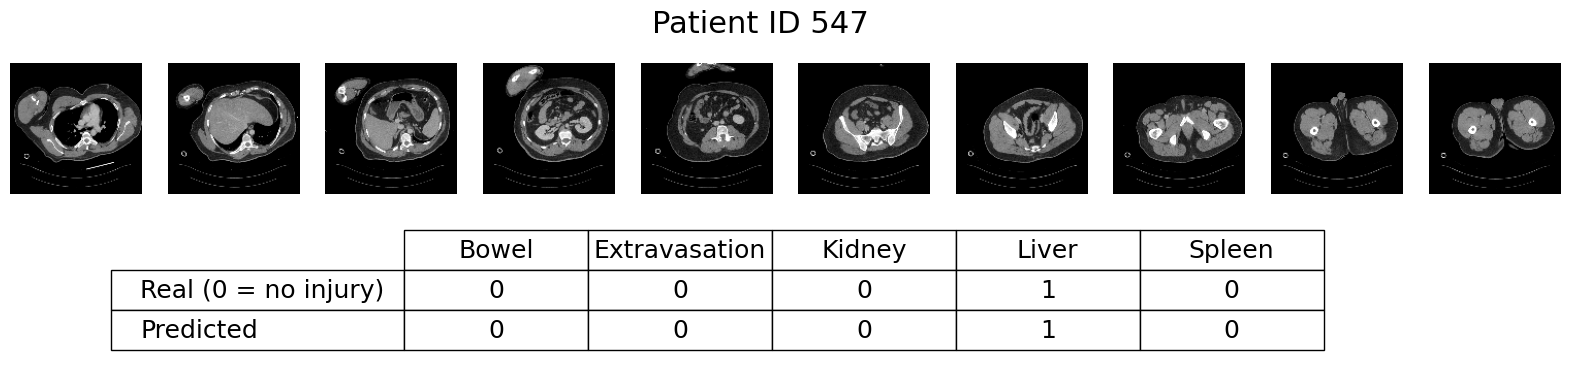

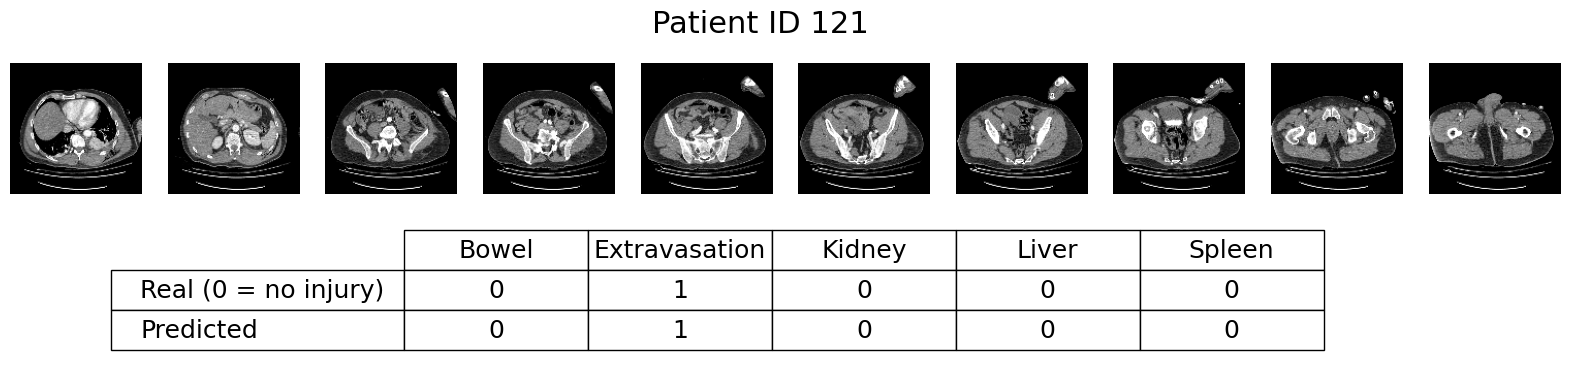

In [8]:
num_images_to_show = 10
model.eval()

# use injuries_dataset or patient_dataset
patient_ids, dataloader = get_reduced_dataloader(injuries_dataset, random_samples=20)
for patient_index, (data, labels) in enumerate(dataloader):
    outputs = model(data.float())
    pred = (outputs > 0.5).int()

    images_to_show = get_images_to_show(data)

    show_scans_with_labels(patient_ids[patient_index], num_images_to_show, images_to_show, labels, pred)